In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import os.path as path

import tensorflow as tf
import keras
import keras_tuner
from keras.layers import Dense, \
                         Dropout

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from BPNN import BPNN

# Feature Processing

In [2]:
scaler = StandardScaler()

N_SYSTEMS = 265

# read all systems
X = np.array(
    [
        pd.read_csv(
            f"./dat/symmetries/sym{str(idx).zfill(4)}.csv"
        ).to_numpy()
        for idx in range(1, N_SYSTEMS + 1)
    ]
)[:, :26, :]
# symmetries with 25 rows were calculated from SymmetryCalculator,
# it can go up to 95 atoms but it's too slow

#for idx, x in enumerate(X):
#    X[idx] = scaler.fit_transform(x)

# read energy file
y = pd.read_csv(
    "./dat/energies.csv"
)[0:N_SYSTEMS]

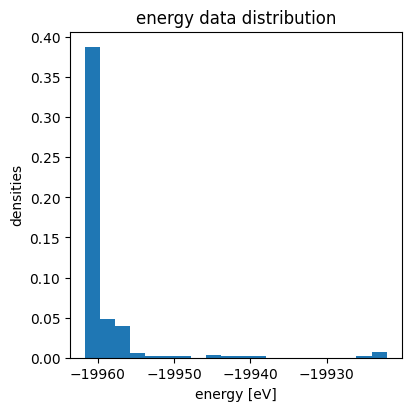

In [3]:
fig, ax = plt.subplots(
    nrows = 1, 
    ncols = 1, 
    figsize = (4,4), 
    constrained_layout = True
)

ax.set_title("energy data distribution")
ax.set_xlabel("energy [eV]")
ax.set_ylabel("densities")
ax.hist(y, bins = 20, density = True)

plt.show()
fig.savefig("e_dist.pdf")

In [4]:
X, y = shuffle(X, y)

lo = int(0.6 * N_SYSTEMS)
hi = int(0.8 * N_SYSTEMS)

X_train = X[:lo]
X_val   = X[lo:hi]
X_test  = X[hi:]

y_train = y[:lo]
y_val   = y[lo:hi]

# for use in plotting
y_test  = y[hi:].to_numpy().reshape(-1)

# Constructing BPNN (exploration)

In [5]:
model = BPNN([
        Dense(16, activation = "relu"),
        Dense(32, activation = "relu"),
        Dense(16, activation = "relu")
    ])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = keras.losses.MeanAbsoluteError(),
    metrics = [keras.metrics.RootMeanSquaredError()]
)

In [6]:
n_epochs = 80
batch_sz = 20

bpnn = model.fit(
    X_train, y_train,
    batch_size = batch_sz,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

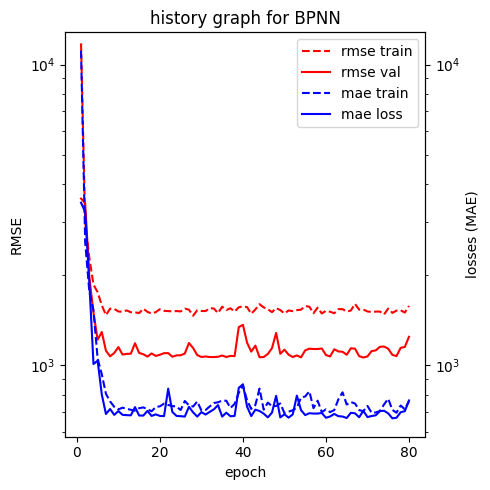

In [7]:
xax = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
ax.set_title("history graph for BPNN")
ax.set_xlabel("epoch")

tax = ax.twinx()

tax.set_ylabel("losses (MAE)")
ax.set_ylabel("RMSE")

ax.plot(
    xax, 
    bpnn.history["root_mean_squared_error"],
    "r--",
    label = "rmse train"
)

ax.plot(
    xax,
    bpnn.history["val_root_mean_squared_error"],
    "r-",
    label = "rmse val"
)

tax.plot(
    xax, 
    bpnn.history["loss"],
    "b--",
    label = "mae train"
)

tax.plot(
    xax, 
    bpnn.history["val_loss"],
    "b",
    label = "mae loss"
)


ax.set_yscale("log")
tax.set_yscale("log")
ax.set_ylim(tax.get_ylim())

lns = [*ax.lines, *tax.lines]
labels = [ln.get_label() for ln in lns]

ax.legend(lns, labels)
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


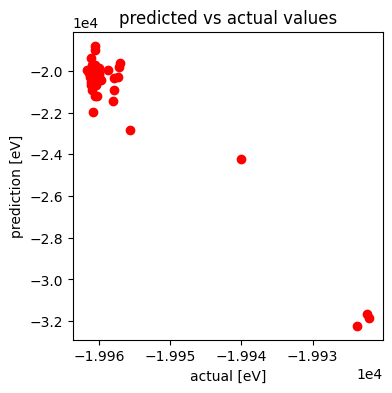

In [8]:
preds = model.predict(X_test)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
ax.set_title("predicted vs actual values")
ax.set_ylabel("prediction [eV]")
ax.set_xlabel("actual [eV]")
ax.ticklabel_format(axis = "both", style="sci", scilimits=(0,0))

ax.scatter(y_test, preds, marker = "o", c="red")

plt.show()

(53,)


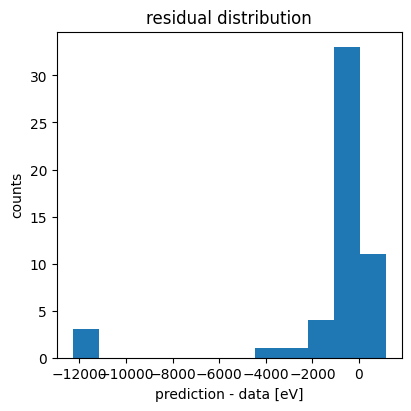

In [9]:
print(np.shape(y_test))

diff = preds - y_test
fig, ax = plt.subplots(
    nrows = 1, 
    ncols = 1, 
    figsize = (4,4), 
    constrained_layout = True
)

ax.set_title("residual distribution")
ax.set_xlabel("prediction - data [eV]")
ax.set_ylabel("counts")
ax.hist(diff, bins = 12)

plt.show()

# Hyperparameter Tuning

In [10]:
def build_model(hp):
    tf.keras.backend.clear_session()
    n_layers = hp.Choice("layers", [4, 5, 6])
    units    = hp.Choice("units", [16, 32, 64])
    lrs      = hp.Choice("learn_rates", [0.0005, 0.0001, 0.00005])

    layers = []
    for _ in range(n_layers):
        layers.append(
            Dense(units, activation = "relu")
        )

    model = BPNN(layers)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lrs),
        loss = keras.losses.MeanAbsoluteError(),
        metrics = [keras.metrics.RootMeanSquaredError()]
    )

    return model

In [11]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective = "val_root_mean_squared_error",
    max_trials = 27
)

tuner.search(
    X_train, y_train,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

Reloading Tuner from .\untitled_project\tuner0.json


In [12]:
tuned_hp = tuner.get_best_hyperparameters()[0]
tf.keras.backend.clear_session()
m_tuned = tuner.hypermodel.build(tuned_hp)
bpnn_tuned = m_tuned.fit(
    X_train, y_train,
    batch_size = batch_sz,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

In [13]:
print(tuned_hp.values)
tuner.results_summary(3)

{'layers': 5, 'units': 64, 'learn_rates': 0.0001}
Results summary
Results in .\untitled_project
Showing 3 best trials
Objective(name="val_root_mean_squared_error", direction="min")

Trial 16 summary
Hyperparameters:
layers: 5
units: 64
learn_rates: 0.0001
Score: 594.3982543945312

Trial 21 summary
Hyperparameters:
layers: 6
units: 32
learn_rates: 0.0005
Score: 636.212890625

Trial 18 summary
Hyperparameters:
layers: 6
units: 16
learn_rates: 0.0005
Score: 645.6551513671875


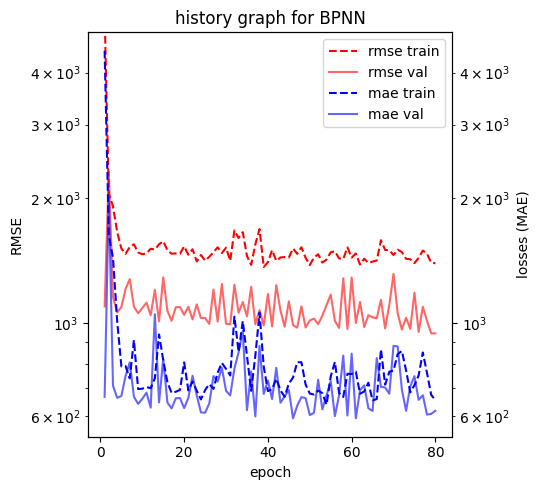

In [21]:
import matplotlib.pyplot as plt

xax = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5.5, 5))
ax.set_title("history graph for BPNN")
ax.set_xlabel("epoch")

tax = ax.twinx()

tax.set_ylabel("losses (MAE)")
ax.set_ylabel("RMSE")

ax.plot(
    xax, 
    bpnn_tuned.history["root_mean_squared_error"],
    "r--",
    label = "rmse train"
)

ax.plot(
    xax,
    bpnn_tuned.history["val_root_mean_squared_error"],
    "r-",
    alpha = 0.6,
    label = "rmse val"
)

tax.plot(
    xax, 
    bpnn_tuned.history["loss"],
    "b--",
    label = "mae train"
)

tax.plot(
    xax, 
    bpnn_tuned.history["val_loss"],
    "b",
    alpha = 0.6,
    label = "mae val"
)


ax.set_yscale("log")
tax.set_yscale("log")
ax.set_ylim(tax.get_ylim())

lns = [*ax.lines, *tax.lines]
labels = [ln.get_label() for ln in lns]

ax.legend(lns, labels)
plt.tight_layout()
plt.show()

fig.savefig("history.pdf")

In [15]:
preds = m_tuned.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step


# Residuals

347.76018672207573 2464.304494981898


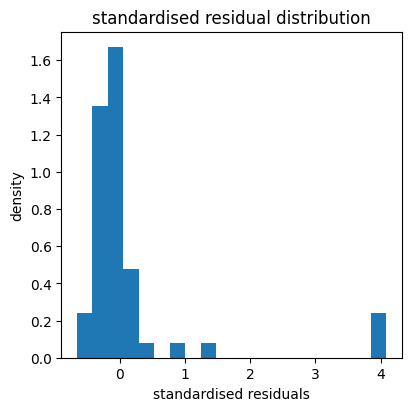

In [16]:
diff = y_test - preds

print(np.mean(diff), np.std(diff))

all_vals = np.append(preds, y)

fig, ax = plt.subplots(
    nrows = 1, 
    ncols = 1, 
    figsize = (4,4), 
    constrained_layout = True
)

ax.set_title("standardised residual distribution")
ax.set_xlabel("standardised residuals")
ax.set_ylabel("density")
# rescale to standard normal
ax.hist(diff  / np.std(diff), bins = 20, density = True)

plt.show()
fig.savefig("res_dist.pdf")

In [17]:
k  = diff / (1 + y_test)
print(k)
print(np.mean(np.abs(k) > 0.15))

[ 0.01241653  0.01818178  0.04026059  0.00747866  0.0062299   0.05471157
 -0.00799459 -0.49269864  0.02869068 -0.15753949 -0.00719918  0.02593771
  0.005771    0.00359601  0.01634876  0.03610168  0.0256438   0.0312407
 -0.01206423  0.02231275  0.01998304 -0.02043837  0.02707553 -0.05318694
 -0.10832973  0.01470874  0.00821786  0.00201254  0.02445773  0.04022549
  0.01579416 -0.03220815 -0.00133884  0.02316993  0.01864163  0.08145332
  0.01670242  0.01837735  0.01117631  0.03157379 -0.50126473  0.07046498
  0.02809819  0.03629562  0.01191368  0.03743801  0.02216212 -0.01795875
  0.02455322  0.04095518 -0.00071359  0.03156762 -0.5054553 ]
0.07547169811320754


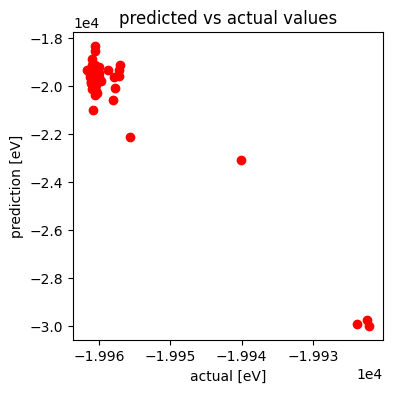

In [18]:

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
ax.set_title("predicted vs actual values")
ax.set_ylabel("prediction [eV]")
ax.set_xlabel("actual [eV]")
ax.ticklabel_format(axis = "both", style="sci", scilimits=(0,0))

ax.scatter(y_test, preds, marker = "o", c="red")

plt.show()